In [1]:
import os
import pathlib
import datetime

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
data_dir = pathlib.Path('D:/Databases/persian digits audio/augmented')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

In [3]:
numbers = np.array(tf.io.gfile.listdir(str(train_dir)))
print('numbers:', numbers)

numbers: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [59]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=train_dir,
    batch_size=32,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,    # fill or truncate data to 16000
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 10308 files belonging to 10 classes.
Using 8247 files for training.
Using 2061 files for validation.

label names: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [5]:
dt, lb = next(iter(train_ds))
print(dt.shape)
print(lb.shape)

(32, 16000, 1)
(32,)


In [6]:
test_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=test_dir,
    batch_size=32,
    seed=0,
    output_sequence_length=16000)    # fill or truncate data to 16000

Found 1105 files belonging to 10 classes.


In [7]:
dt, lb = next(iter(test_ds))
print(dt.shape)
print(lb.shape)

(32, 16000, 1)
(32,)


In [8]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)
test_ds = test_ds.map(squeeze, tf.data.AUTOTUNE)

In [9]:
dt, lb = next(iter(train_ds))
print(dt.shape)
print(lb.shape)

(32, 16000)
(32,)


In [10]:
dt, lb = next(iter(test_ds))
print(dt.shape)
print(lb.shape)

(32, 16000)
(32,)


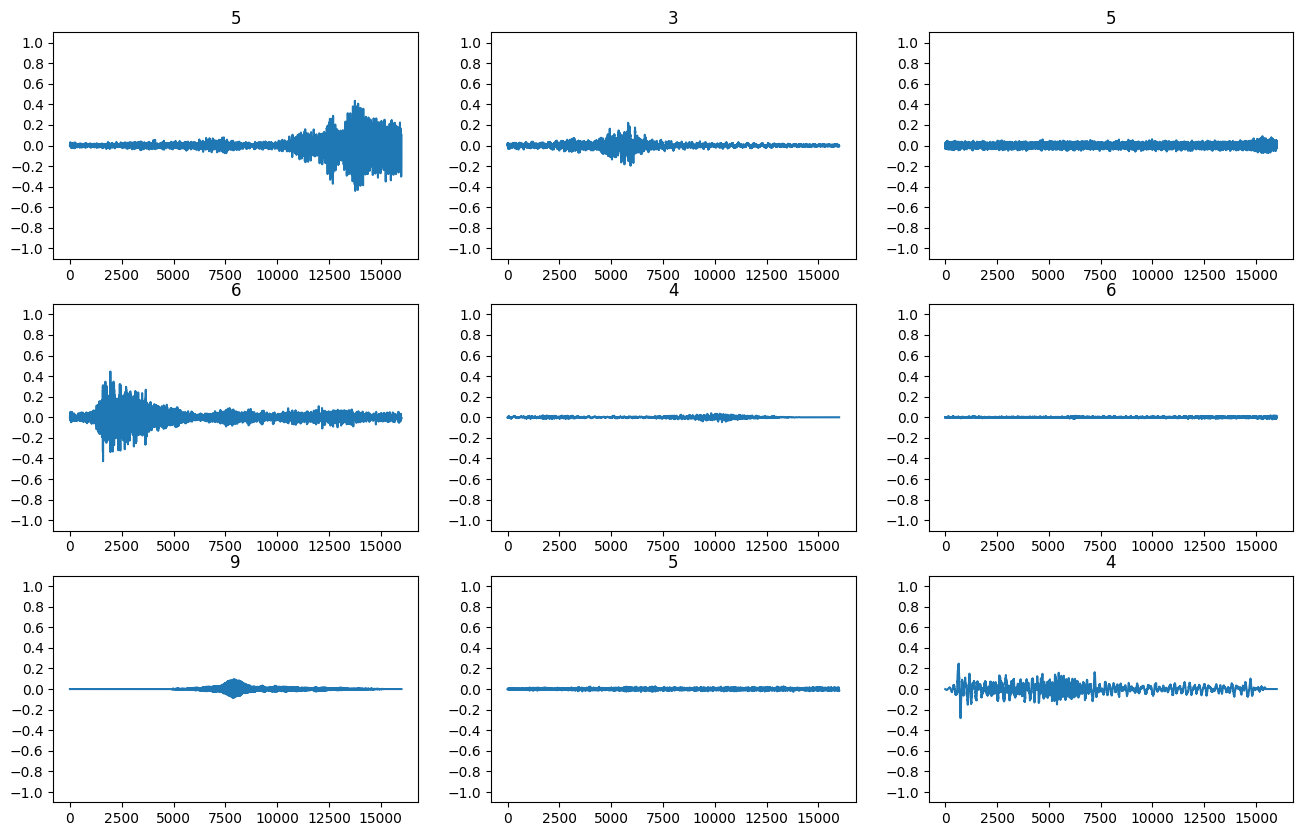

In [11]:
dt, lb = next(iter(train_ds))

plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols

for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = dt[i]
  plt.plot(audio_signal)
  plt.title(label_names[lb[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [12]:
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [13]:
# dt, lb = next(iter(train_ds))

for i in range(3):
    label = label_names[lb[i]]
    waveform = dt[i]
    spectrogram = get_spectrogram(waveform)
    
    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=16000))

Label: 5
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: 3
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: 5
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [14]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)

  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

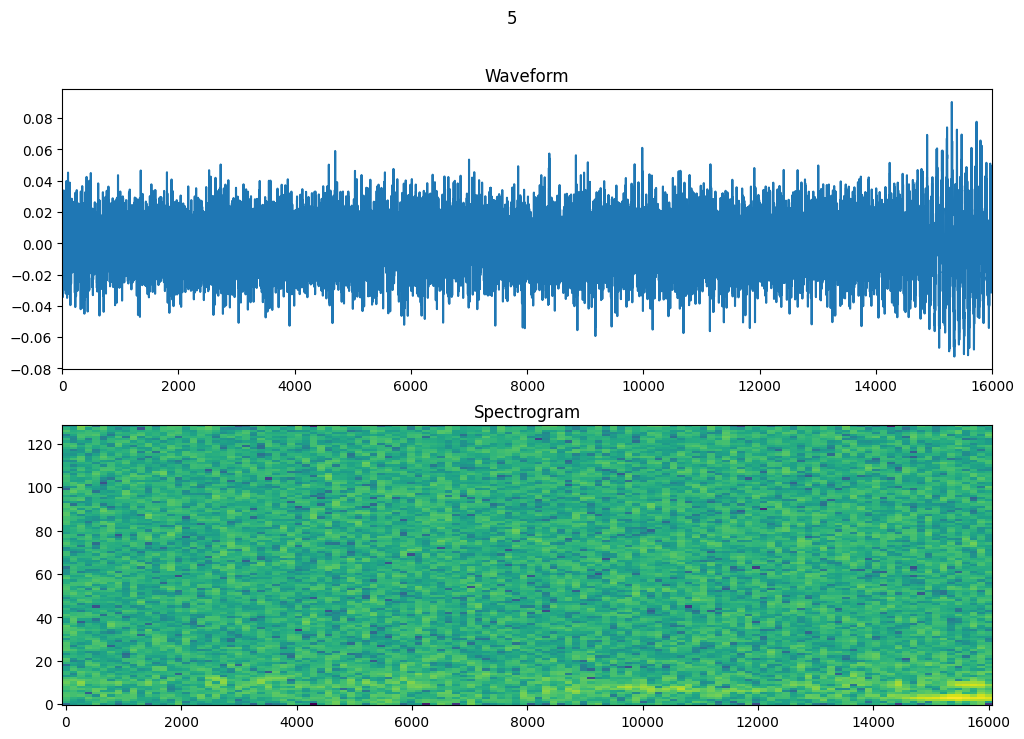

In [15]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [16]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [17]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [18]:
dt, lb = next(iter(train_spectrogram_ds))
print(dt.shape)
print(lb.shape)

(32, 124, 129, 1)
(32,)


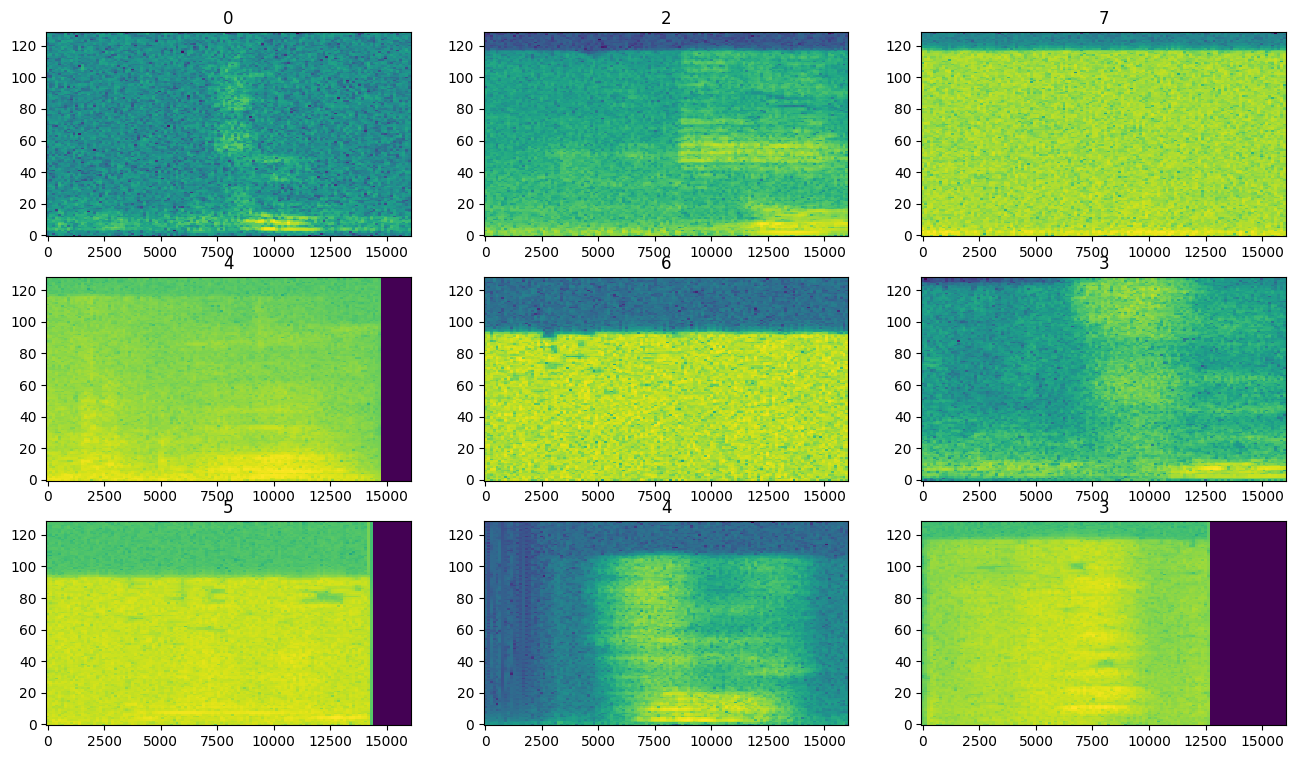

In [19]:
# dt, lb = next(iter(train_spectrogram_ds))

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(dt[i].numpy(), ax)
    ax.set_title(label_names[lb[i].numpy()])

plt.show()

## Build and train the model

In [20]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [21]:
input_shape = dt.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

Input shape: (124, 129, 1)


In [ ]:
normalize_layer = layers.Normalization()
normalize_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

In [ ]:
model = models.Sequential([
    layers.Input(shape=input_shape),

    layers.Resizing(124, 124),
    normalize_layer,

    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.SpatialDropout2D(0.2),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.SpatialDropout2D(0.3),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.SpatialDropout2D(0.3),
    layers.MaxPooling2D(),

    layers.Conv2D(256, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.SpatialDropout2D(0.4),
    layers.MaxPooling2D(),

    layers.Conv2D(512, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(512, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(512, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.SpatialDropout2D(0.4),
    layers.MaxPooling2D(),

    layers.GlobalAveragePooling2D(),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(num_labels),
])


model.summary()

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

model trained in google colab and loaded here

https://colab.research.google.com/drive/1Bu-4li1naAYnLKG7tuEOT4vkHlKC9zqI?usp=sharing

In [22]:
model = models.load_model('model1.keras')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 124, 124, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 124, 124, 1)         │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 124, 124, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 124, 124, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 124, 124, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 124, 124, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 124, 124, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 124, 124, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d (SpatialDropout2D) │ (None, 124, 124, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 62, 62, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 62, 62, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 62, 62, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 62, 62, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 62, 62, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 62, 62, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d_1                  │ (None, 62, 62, 64)          │               0 │
│ (SpatialDropout2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 31, 31, 64)          │              

 Total params: 24,037,539 (91.70 MB)

 Trainable params: 8,010,314 (30.56 MB)

 Non-trainable params: 6,595 (25.77 KB)

 Optimizer params: 16,020,630 (61.11 MB)

## Predict my digits

In [38]:
my_digits_dir = 'mydigits/'
my_digits_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=my_digits_dir,
    batch_size=32,
    shuffle=False,
    output_sequence_length=16000)    # fill or truncate data to 16000

Found 10 files belonging to 10 classes.


In [39]:
class_names = my_digits_ds.class_names
class_names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [40]:
my_digits_ds = my_digits_ds.map(squeeze, tf.data.AUTOTUNE)

In [41]:
my_digits_spectrogram_ds = make_spec_ds(my_digits_ds)

In [42]:
dt, lb = next(iter(my_digits_spectrogram_ds))
print(dt.shape)
print(lb.shape)

(10, 124, 129, 1)
(10,)


In [43]:
model.evaluate(my_digits_spectrogram_ds, return_dict=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step - accuracy: 1.0000 - loss: 1.1516e-04


{'accuracy': 1.0, 'loss': 0.00011516160884639248}

In [44]:
y_pred = model.predict(my_digits_spectrogram_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


In [45]:
y_pred = tf.argmax(y_pred, axis=1)

In [46]:
for i, (audio, label) in enumerate(my_digits_spectrogram_ds.unbatch()):
    real_class_name = class_names[label.numpy()]
    predicted_class_name = class_names[y_pred[i]]
    
    print(f"Sample {i+1}: Real Class = {real_class_name}, Predicted Class = {predicted_class_name}")

Sample 1: Real Class = 0, Predicted Class = 0
Sample 2: Real Class = 1, Predicted Class = 1
Sample 3: Real Class = 2, Predicted Class = 2
Sample 4: Real Class = 3, Predicted Class = 3
Sample 5: Real Class = 4, Predicted Class = 4
Sample 6: Real Class = 5, Predicted Class = 5
Sample 7: Real Class = 6, Predicted Class = 6
Sample 8: Real Class = 7, Predicted Class = 7
Sample 9: Real Class = 8, Predicted Class = 8
Sample 10: Real Class = 9, Predicted Class = 9


## Connect to microphone

In [34]:
import pyaudio
import wave
import numpy as np
from scipy.io import wavfile
from IPython.display import Audio
from IPython import display

In [35]:
audio = pyaudio.PyAudio()

# List all available audio devices
print("Available audio input devices:")
for i in range(audio.get_device_count()):
    device_info = audio.get_device_info_by_index(i)
    if device_info["maxInputChannels"] > 0:
        print(f"Device Index: {i}, Name: {device_info['name']}")

audio.terminate()

Available audio input devices:
Device Index: 0, Name: Microsoft Sound Mapper - Input
Device Index: 1, Name: Microphone (WO Mic Device)
Device Index: 2, Name: Microphone (2- High Definition 
Device Index: 3, Name: Microphone (2- High Definition 
Device Index: 7, Name: Primary Sound Capture Driver
Device Index: 8, Name: Microphone (WO Mic Device)
Device Index: 9, Name: Microphone (2- High Definition Audio Device)
Device Index: 10, Name: Microphone (2- High Definition Audio Device)
Device Index: 16, Name: Microphone (2- High Definition Audio Device)
Device Index: 17, Name: Microphone (WO Mic Device)
Device Index: 18, Name: Microphone (2- High Definition Audio Device)
Device Index: 20, Name: Microphone (HD Audio Mixed capture)
Device Index: 22, Name: Microphone (WO Mic Wave)


In [93]:
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 16000
CHUNK = 1024
RECORD_SECONDS = 1
DEVICE_INDEX = 1

print(f"Recording from device index {DEVICE_INDEX}...")

while True:
    if keyboard.is_pressed('q'):
        print("\nStopping...")
        break

    
    OUTPUT_FILENAME = f"recorded/stream_output.wav"
    
    # Initialize PyAudio
    audio = pyaudio.PyAudio()
    
    # Start Recording
    stream = audio.open(format=FORMAT,
                        channels=CHANNELS,
                        rate=RATE,
                        input=True,
                        input_device_index=DEVICE_INDEX,
                        frames_per_buffer=CHUNK)
    
    
    frames = []
    
    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)
    
    # print("Finished recording.")
    
    # Stop and close the stream
    stream.stop_stream()
    stream.close()
    audio.terminate()
    
    # Save the recorded data to a WAV file
    with wave.open(OUTPUT_FILENAME, 'wb') as wf:
        wf.setnchannels(CHANNELS)
        wf.setsampwidth(audio.get_sample_size(FORMAT))
        wf.setframerate(RATE)
        wf.writeframes(b''.join(frames))
    
    audio_binary = tf.io.read_file(OUTPUT_FILENAME)
    audio, sample_rate = tf.audio.decode_wav(audio_binary, desired_channels=1)
    audio = tf.expand_dims(audio, axis=0)
    audio = tf.squeeze(audio, axis=-1)
    audio_spectogram = get_spectrogram(audio)
    # print(audio_spectogram.shape)

    pred = model.predict(audio_spectogram, verbose=0)
    pred = tf.argmax(pred, axis=1)
    print(class_names[pred[0]], end=' - ')

    os.remove(OUTPUT_FILENAME)

Recording from device index 1...
4 - 0 - 5 - 2 - 0 - 1 - 2 - 3 - 4 - 5 - 6 - 7 - 8 - 3 - 3 - 9 - 4 - 4 - 5 - 7 - 3 - 3 - 9 - 5 - 8 - 3 - 3 - 8 - 7 - 8 - 3 - 5 - 
Stopping...
